<a href="https://colab.research.google.com/github/anki079/Object-Recognition-Project/blob/master/Object_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Ankita Tripathi      <br/>
Python: 2.7.15+         <br/>
OpenCV: 3.4.**3** 

This project was done as part of a class on Robotic Systems, taught at UCF in the Fall 2019 semester. 

The objective of this project was to perform a comparative analysis of different image recognition techniques using OpenCV. Template matching and color histogram matching were the two techniques being compared here. 

A full report can be found at: https://docs.google.com/document/d/1Q_RvMozklTbK1Sw3rMll9WnEWfpSIKUz1tsX77FE0b8/edit?usp=sharing

In [0]:
import cv2
import sys
print("OpenCV: ", cv2.__version__)
print("Python: ", sys.version)

('OpenCV: ', '3.4.3')
('Python: ', '2.7.15+ (default, Oct  7 2019, 17:39:04) \n[GCC 7.4.0]')


In [0]:
# Here, we import the required libraries
import glob
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [0]:
# Loading the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# After executing the cell above, Store the images directory with the images 
# inside it in your notebook. Check the images with the below command
!ls "/content/drive/My Drive/Colab Notebooks/Object Recognition Project/images"

ukbench00020.jpg  ukbench00285.jpg  ukbench00722.jpg  ukbench01495.jpg
ukbench00021.jpg  ukbench00286.jpg  ukbench00723.jpg  ukbench09120.jpg
ukbench00022.jpg  ukbench00287.jpg  ukbench01492.jpg  ukbench09121.jpg
ukbench00023.jpg  ukbench00720.jpg  ukbench01493.jpg  ukbench09122.jpg
ukbench00284.jpg  ukbench00721.jpg  ukbench01494.jpg  ukbench09123.jpg


In [0]:
# Getting all images
images = glob.glob("/content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/*.jpg")
print images[19]

/content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123.jpg


In [0]:
class object_recognition():

    def matching(self, tm_meth, ch_meth, query_input):
        final_matches_list = []
#         inst_match={"query":"", "all_matches" : []}
        
        if query_input is not None:
            queue_label = query
            queue_img = query_images_list
        else:
            queue_label = images
            queue_img = template_images_list
            
        for i, inst in enumerate(queue_label):
            #Getting the name of the image file without the extension
            inst_match={"query":'', "all_matches" : [],"ch_sorted":[],"tm_sorted":[]}
            inst_match["query"] = inst.partition('/')[2].split('.')[0]
            ch = []
            tm = []
            
            all_matches_list =[]
            for j, tmp in enumerate(images):

                # Applying template matching
                result = cv2.matchTemplate(template_images_list[j], queue_img[i],tm_meth)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

                
                # Applying color histogram matching
                query_hist = cv2.calcHist(queue_img[i],[0], None, [256], [0,256])
                temp_hist = cv2.calcHist(template_images_list[j],[0], None, [256], [0,256])
                color_histogram = cv2.compareHist(query_hist,temp_hist,ch_meth)
                             
                all_matches_list.append([tmp.partition('/')[2].split('.')[0], max_val, color_histogram])
                ch.append([tmp.partition('/')[2].split('.')[0], color_histogram])
                tm.append([tmp.partition('/')[2].split('.')[0], max_val])
                
                ch = sorted(ch, key = itemgetter(1), reverse = False)
                tm = sorted(tm, key = itemgetter(1), reverse = True)
            inst_match["all_matches"] = all_matches_list
            inst_match["ch_sorted"] = ch
            inst_match["tm_sorted"] = tm
            final_matches_list.append(inst_match)

        return final_matches_list

      
    '''This function contains the scoring procedure. Returns a dictionary with the score values and the top 4 dictionary'''
    def scoring(self, match_result_list):

        sorted_scored_list = []

        for i in (match_result_list):

          sortdict = {"q":'', "tm4":[],"ch4":[], "tm_score" : 0, "ch_score" : 0}

          sortdict["q"] = i["query"] 
          sortdict["tm4"] = i["tm_sorted"][:4]
          sortdict["ch4"] = i["ch_sorted"][:4]

          sortdict["tm_score"] = self.match_class(sortdict["q"],sortdict["tm4"])
          sortdict["ch_score"] = self.match_class(sortdict["q"],sortdict["ch4"])
          
          sorted_scored_list.append(sortdict)

        return sorted_scored_list


# ''' This function calculates the mean match score normalized to a range of [0,1]'''
    def eval_cal(self, scoring_result):
        
        tm = []
        ch = []

        for i in range(len(scoring_result)):
          tm.append(scoring_result[i]["tm_score"])
          ch.append(scoring_result[i]["ch_score"])
        
        norm_tm = [float(i/4) for i in tm]
        norm_ch = [float(j/4) for j in ch]

        mean_tm = sum(norm_tm) / 20
        mean_ch = sum(norm_ch) / 20

        normed_sd_tm = np.std(norm_tm)
        normed_sd_ch = np.std(norm_ch)

        print
        print 'Graph of mean and standard deviation:'

        techniques = ['Color Histogram Matching', 'Template Matching']
        x_pos = np.arange(len(techniques))
        m_scores = [mean_ch,mean_tm]
        error = [normed_sd_ch, normed_sd_tm]

        fig, ax = plt.subplots()
        ax.bar(x_pos, m_scores, yerr = error, align = 'center', alpha = 0.5, ecolor = 'black', capsize = 10)
        ax.set_ylabel('Mean')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(techniques)
        ax.set_title('Comparison of Object Recognition Techniques')
        ax.yaxis.grid(True)

        plt.tight_layout()
        plt.savefig('_obj_rec_graph_mean_sd.png')
        plt.show()

        print'Standard Deviation of Color Histogram matching: '+str(normed_sd_ch)
        print'Standard Deviation of Template matching: '+str(normed_sd_tm)
        print

        return [["Template_match_mean", mean_tm], ["Color_histogram_mean",mean_ch]]

    
    def match_class(self,string,arr):
      
      score = 0
      c1 = ''
      c2 = ''
      c1 = self.get_class(string)
      
      for i in range(4):
        c2 = self.get_class(arr[i][0])
        if c1 == c2:
          score+= 1
      return score

    def get_class(self, string):
      classtype =''
      
      n1 = int((string.rpartition('h')[2]).split('.')[0])
      classes = ['duck','chair','person','painting','photos']
      
      if n1 in range(20, 24):
        classtype = classes[0]
      elif n1 in range(284,288):
        classtype = classes[1]
      elif n1 in range(720,724):
        classtype = classes[2]
      elif n1 in range(1492,1496):
        classtype = classes[3]
      else:
        classtype = classes[4] 
      
      return classtype
    
    ''' This function should be called only to print histograms. Not required for the assignment.'''
    def histprint(self,q_img, t_img):
      q_img = '/'+q_img+'.jpg'
      t_img = '/'+t_img+'.jpg'
      q_hist = cv2.calcHist(cv2.imread(q_img,0),[0], None, [256], [0,256])
      t_hist = cv2.calcHist(cv2.imread(t_img,0),[0], None, [256], [0,256])

      plt.plot(q_hist)
      plt.plot(t_hist)
      plt.show()
      return

    
        

class: person
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722
score_color_hist:  4 /4
score_template_match:  4 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.41082405208759776]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.43265389508550034]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.5085719176419717]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722', 0.9999998211860657]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.35538384318351746]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.3317203223705292]
['content/drive/My Drive/Colab Notebooks/Ob

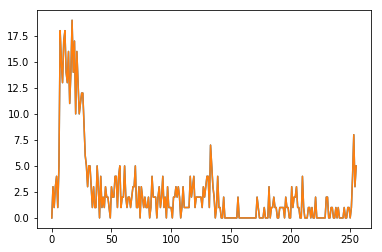

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723


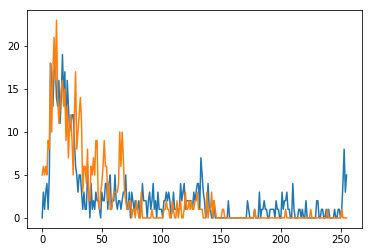

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720


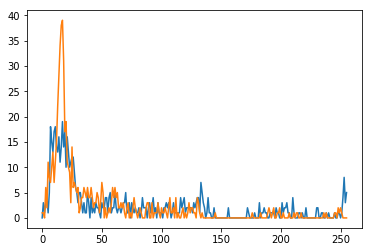

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721


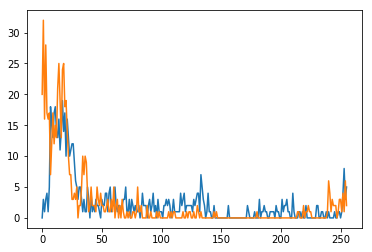


class: person
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723
score_color_hist:  4 /4
score_template_match:  4 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.3949388862751727]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722', 0.41082405208759776]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.4280106061180353]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.49772530794143677]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.49088284373283386]
['content/drive/My Drive/Colab Notebooks/Object Recogniti

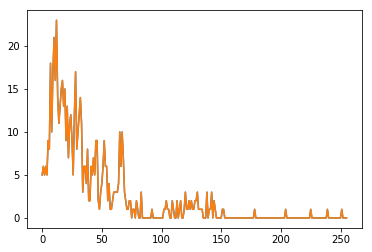

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720


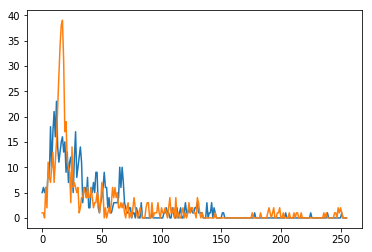

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722


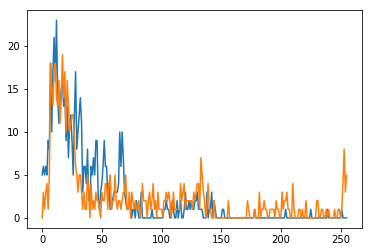

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721


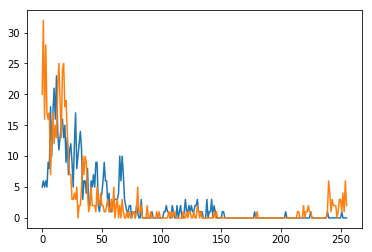


class: chair
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00287
score_color_hist:  3 /4
score_template_match:  1 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00287', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 0.7271936237797327]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.7307115101564978]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.7807622278120706]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00287', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.25190889835357666]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.16847947239875793]
['content/drive/My Drive/Colab Notebooks/Object Recognition

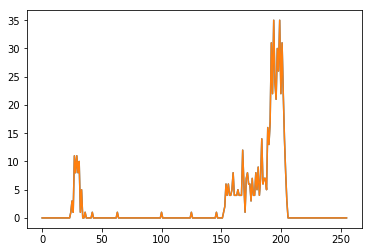

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286


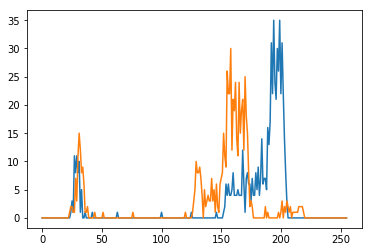

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285


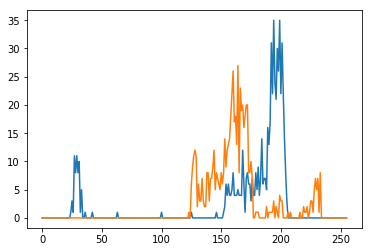

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


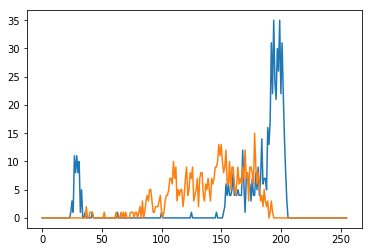


class: chair
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285
score_color_hist:  3 /4
score_template_match:  2 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 0.42723120015476906]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.5400438718982216]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.670940033353393]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.9999999403953552]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 0.24179935455322266]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493', 0.11046137660741806]
['content/drive/My Drive/Colab Notebooks/Obj

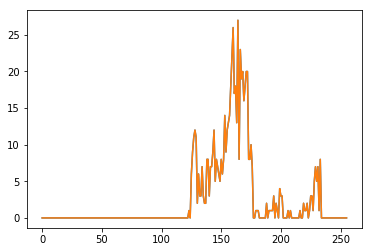

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286


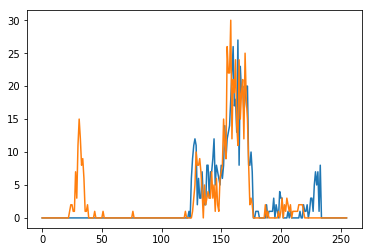

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


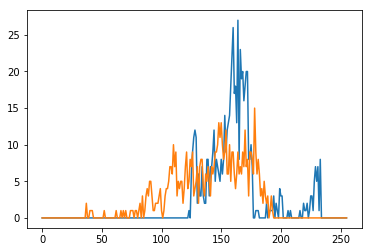

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284


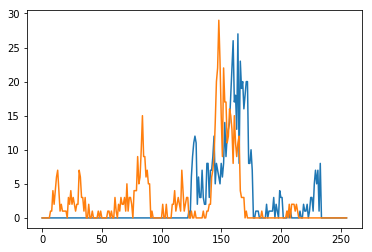


class: person
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721
score_color_hist:  4 /4
score_template_match:  4 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.4280106061180353]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.4365945157222498]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722', 0.5085719176419717]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.9999996423721313]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.49088284373283386]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.47477108240127563]
['content/drive/My Drive/Colab Notebooks/Ob

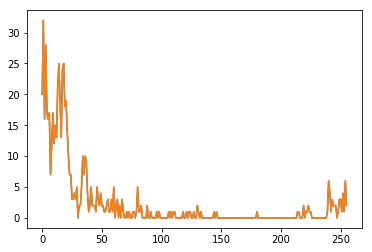

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723


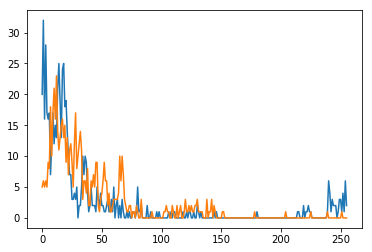

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720


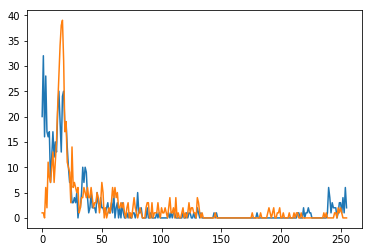

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722


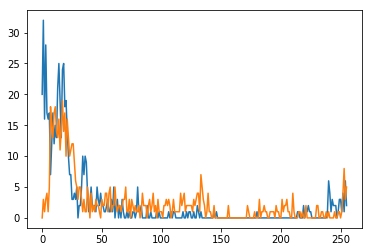


class: chair
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286
score_color_hist:  3 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.42723120015476906]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.6063815782633485]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.6156595575417969]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.31614410877227783]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.24179935455322266]
['content/drive/My Drive/Colab Notebooks/Object Recognitio

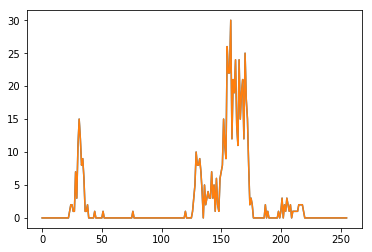

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285


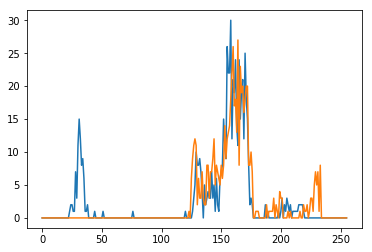

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


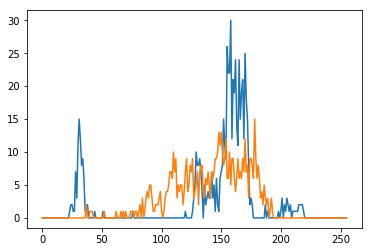

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284


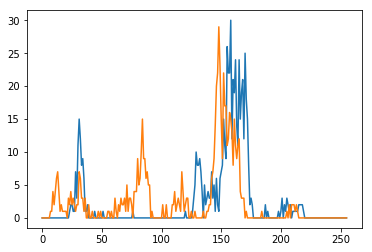


class: chair
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284
score_color_hist:  1 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.5182719228764635]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.6089553386088372]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.610178455823967]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.9999997615814209]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00286', 0.31614410877227783]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.07345738261938095]
['content/drive/My Drive/Colab Notebooks/Obje

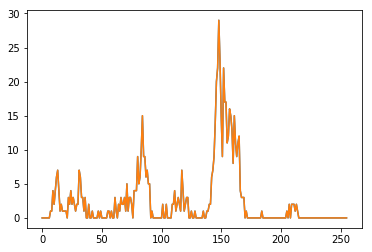

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


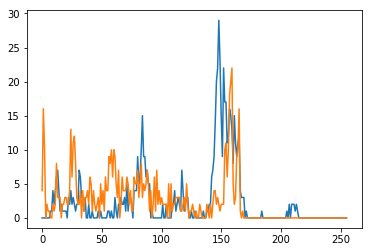

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023


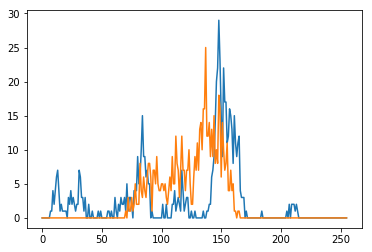

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


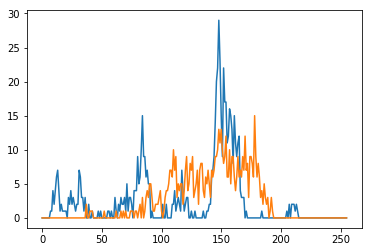


class: person
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720
score_color_hist:  4 /4
score_template_match:  4 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.3949388862751727]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722', 0.43265389508550034]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.4365945157222498]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.49772530794143677]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.47477108240127563]
['content/drive/My Drive/Colab Notebooks/Object Recogniti

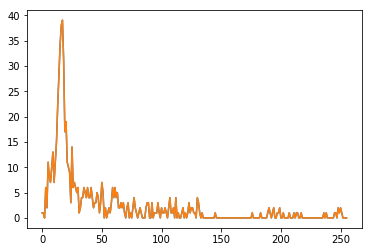

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723


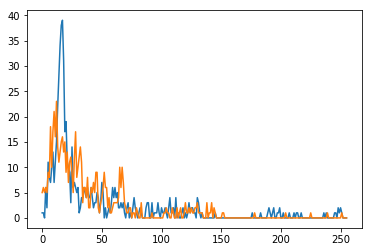

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00722


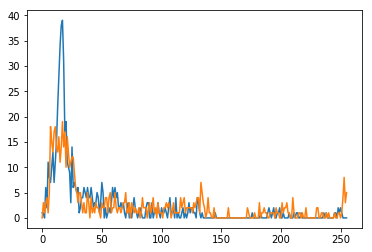

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721


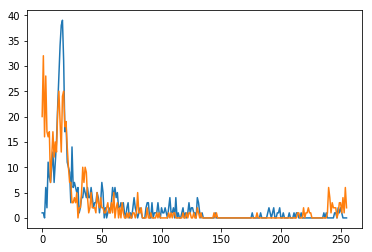


class: duck
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021
score_color_hist:  4 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020', 0.4582298907158055]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.5221300869157806]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.6411798861828022]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.4446888566017151]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00287', 0.16847947239875793]
['content/drive/My Drive/Colab Notebooks/Object Recognition P

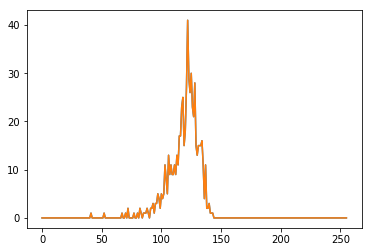

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020


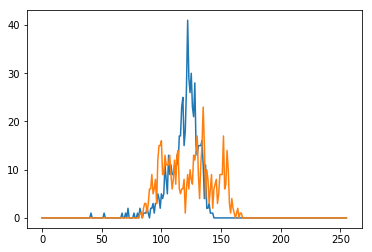

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023


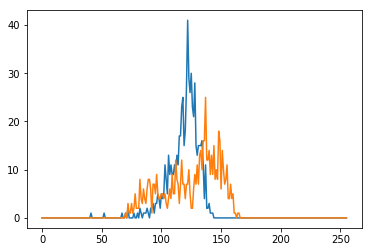

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


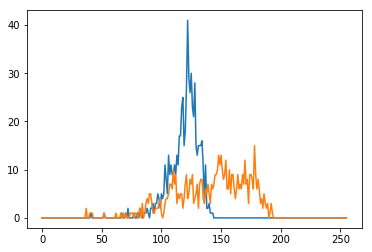


class: duck
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020
score_color_hist:  4 /4
score_template_match:  2 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.3105273016054457]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.4582298907158055]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.487748595354647]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.1205798014998436]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.09054658561944962]
['content/drive/My Drive/Colab Notebooks/Object Recognition Pr

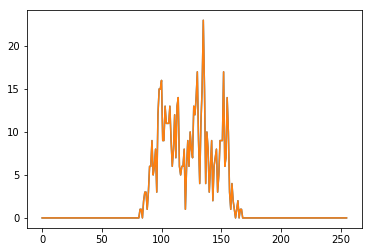

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023


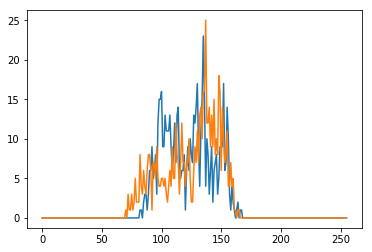

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021


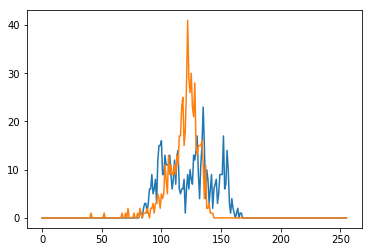

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


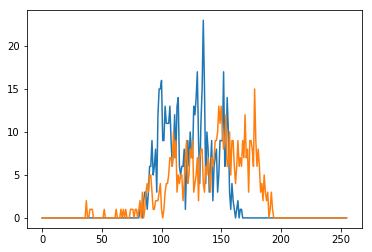


class: painting
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495
score_color_hist:  2 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 0.670227325828597]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.7334897621752358]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.7562915084457271]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.2644469141960144]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493', 0.23662437498569489]
['content/drive/My Drive/Colab Notebooks/Object Recognitio

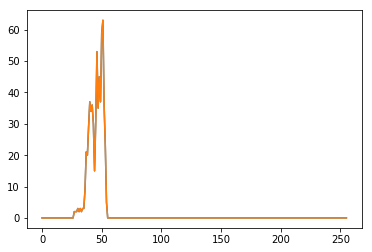

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123


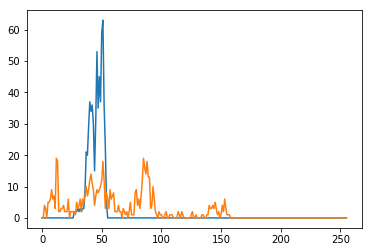

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494


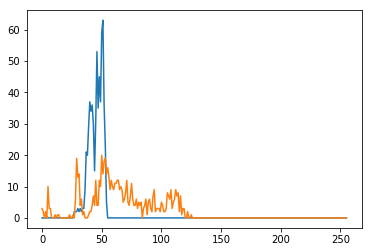

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723


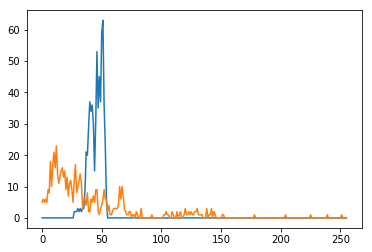


class: duck
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022
score_color_hist:  3 /4
score_template_match:  1 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.4678406223183672]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020', 0.487748595354647]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285', 0.5400438718982216]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.9999989867210388]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 0.26813191175460815]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 0.2023659199476242]
['content/drive/My Drive/Colab Notebooks/Object

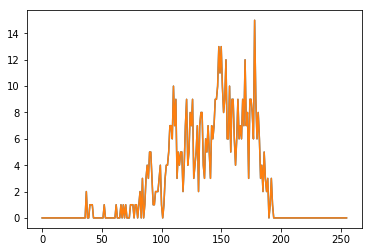

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023


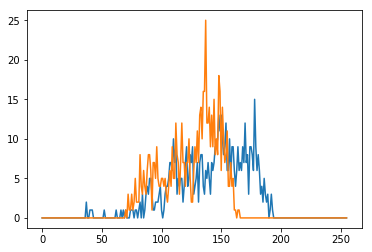

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020


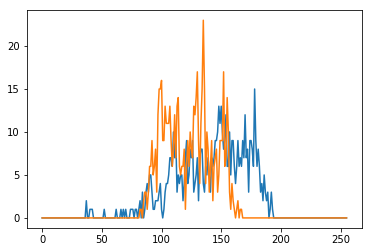

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00285


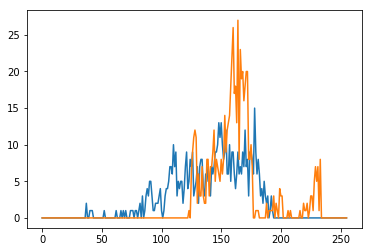


class: painting
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494
score_color_hist:  2 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.40144018630885475]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 0.5526246994065189]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.5872351323334887]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.9999998211860657]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.21592473983764648]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 0.1584150791168213]
['content/drive/My Drive/Colab Notebooks/

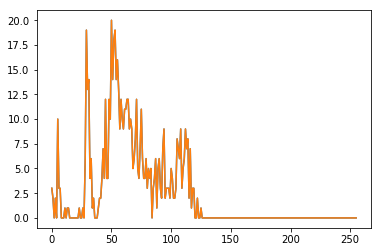

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492


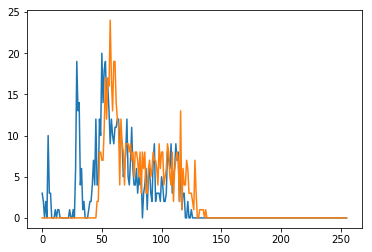

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123


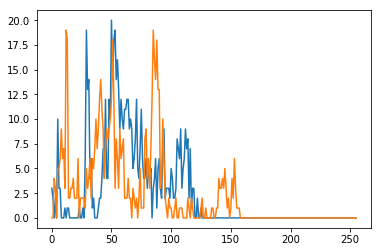

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


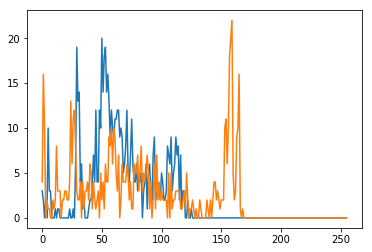


class: duck
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023
score_color_hist:  4 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020', 0.3105273016054457]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.4678406223183672]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.5221300869157806]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00023', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021', 0.4446888566017151]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00287', 0.25190889835357666]
['content/drive/My Drive/Colab Notebooks/Object Recognition P

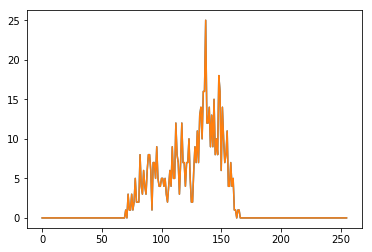

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00020


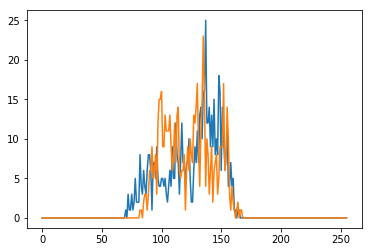

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022


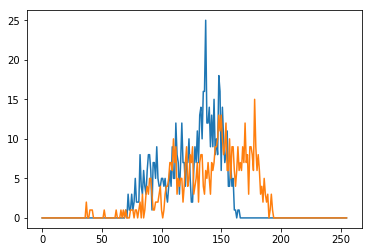

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021


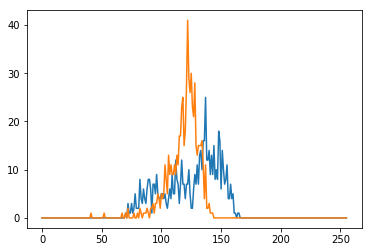


class: painting
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492
score_color_hist:  2 /4
score_template_match:  4 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.40144018630885475]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.612054606388399]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 0.6162564767412558]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493', 0.4755634665489197]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 0.2644467055797577]
['content/drive/My Drive/Colab Notebooks/Object Recognitio

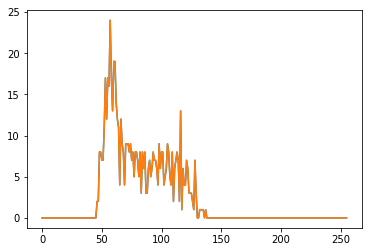

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494


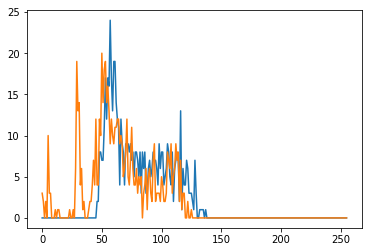

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


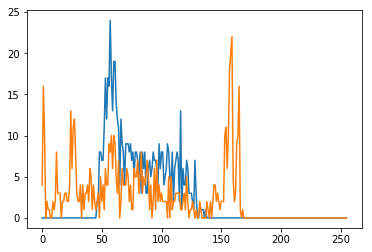

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122


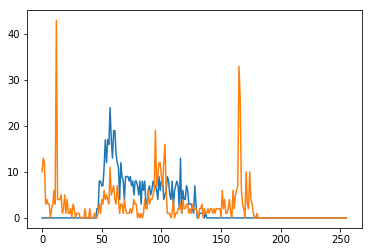


class: photos
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122
score_color_hist:  3 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.4724062595157216]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.5014694990232199]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.6162564767412558]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 0.30480146408081055]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00022', 0.26813191175460815]
['content/drive/My Drive/Colab Notebooks/Object Recognitio

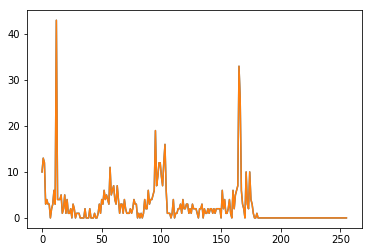

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120


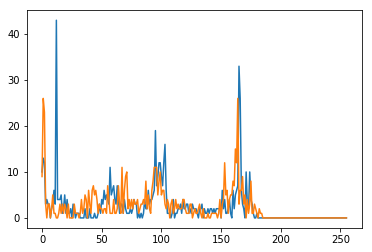

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


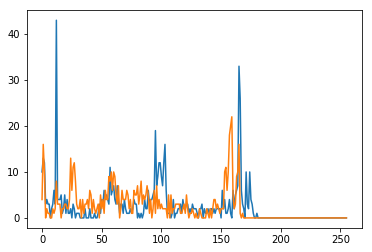

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492


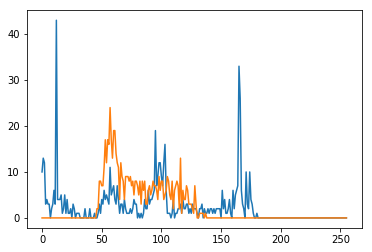


class: painting
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493
score_color_hist:  1 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.7027272112259413]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.725174283118008]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 0.7593464928181506]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01493', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492', 0.4755634665489197]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01495', 0.23662437498569489]
['content/drive/My Drive/Colab Notebooks/Object Recognitio

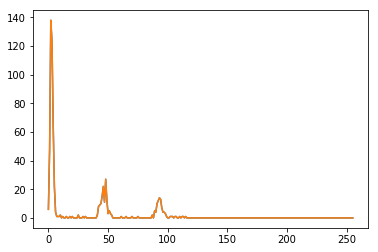

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721


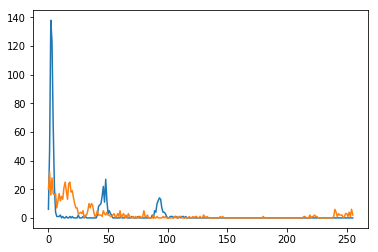

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120


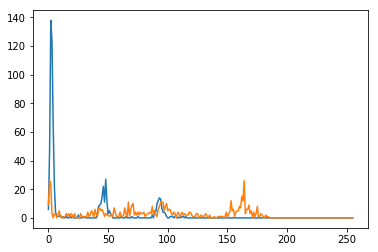

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123


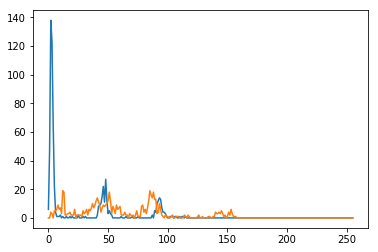


class: photos
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121
score_color_hist:  3 /4
score_template_match:  2 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.46249962715490595]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 0.5014694990232199]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284', 0.5182719228764635]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.9999999403953552]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.3118838965892792]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.23467952013015747]
['content/drive/My Drive/Colab Notebooks/Ob

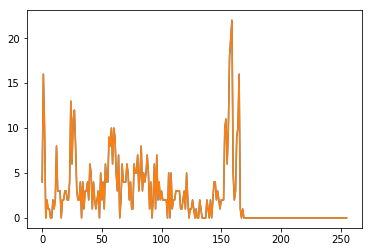

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120


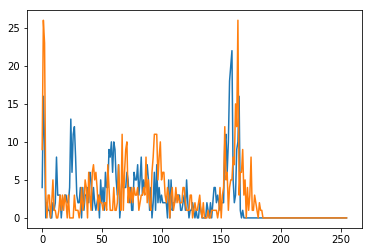

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122


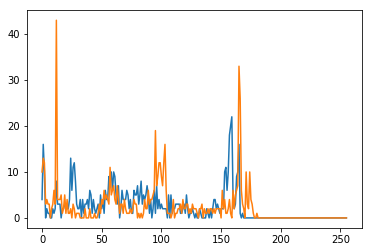

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00284


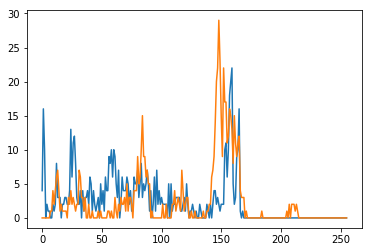


class: photos
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120
score_color_hist:  3 /4
score_template_match:  3 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.46249962715490595]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122', 0.4724062595157216]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.6004574939083598]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09120', 0.9999999403953552]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.3118838965892792]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.29966652393341064]
['content/drive/My Drive/Colab Notebooks/Ob

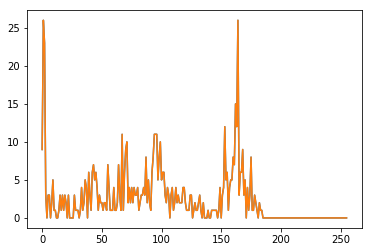

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


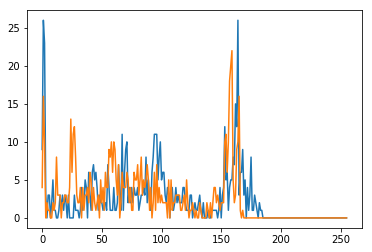

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09122


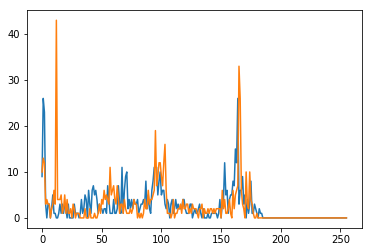

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494


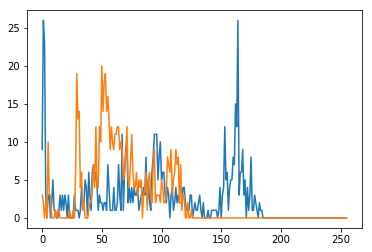


class: photos
query: content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123
score_color_hist:  2 /4
score_template_match:  2 /4
top4_color_hist: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 0.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121', 0.5311103937463633]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723', 0.5488388029157442]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494', 0.5526246994065189]
top4_template_match: 
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09123', 1.0]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00721', 0.3168790936470032]
['content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00720', 0.3049781024456024]
['content/drive/My Drive/Colab Notebooks/Object Recognition 

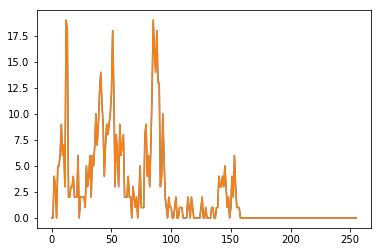

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench09121


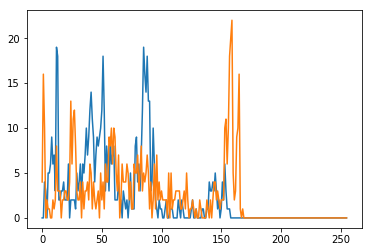

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00723


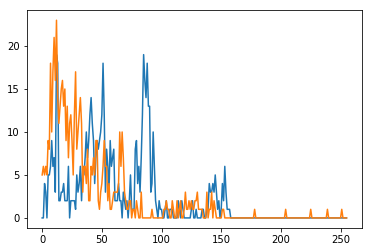

content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01494


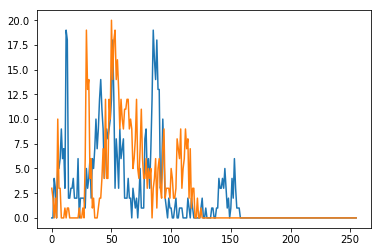



Graph of mean and standard deviation:


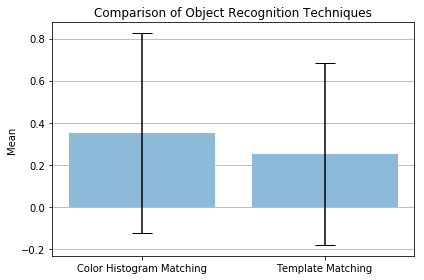

Standard Deviation of Color Histogram matching: 0.4769696007084728
Standard Deviation of Template matching: 0.4330127018922193

{'Color_histogram_mean': 0.35, 'Template_match_mean': 0.25}


In [0]:
 # Main run
  
  query_images_list = []
  template_images_list = []

  '''You can specify the image name as the query for testing. See below'''
#   query = ['/content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench00021.jpg',
#    '/content/drive/My Drive/Colab Notebooks/Object Recognition Project/images/ukbench01492.jpg']
  query = None
  
  try:
      obj_rec = object_recognition()

      # Runs on query_img if arguments are passed, otherwise runs on the entire dataset.
      if query != None:

          for query_img in query:
              query_images_list.append(cv2.imread(query_img, 0))

      for i in range(len(images)):
          template_images_list.append(cv2.imread(images[i], 0))

      tm_methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
      hist_methods = ['cv2.HISTCMP_CORREL','cv2.HISTCMP_CHISQR','cv2.HISTCMP_INTERSECT',
        'cv2.HISTCMP_BHATTACHARYYA']
      
      tm_meth = eval(tm_methods[1])
      ch_meth = eval(hist_methods[3])
            
      matching_results = obj_rec.matching(tm_meth,ch_meth, query)
      sorted_scored_top4 = obj_rec.scoring(matching_results)
      
      ch = []
      tm = []
      for i in sorted_scored_top4:
        ch.append(i["ch_score"])
        tm.append(i["tm_score"])
        ctype = obj_rec.get_class(i["q"])
        print 'class:',ctype
        print'query:',i["q"]
        print'score_color_hist: ',i['ch_score'],'/4'
        print'score_template_match: ',i["tm_score"],'/4'
        
        print'top4_color_hist: '
        for j in range(4):
          print i["ch4"][j]
          
        print'top4_template_match: '
        for k in range(4):
          print i["tm4"][k]
      
        # The following segment is used for displaying the color histograms. It is not required for comparisons.
        print 'color histogram plots:'
        for l in range(4):
          print i["ch4"][l][0]
          obj_rec.histprint(i["q"],i["ch4"][l][0])
          
        print
        
      evaluation_results = obj_rec.eval_cal(sorted_scored_top4)
      print dict(evaluation_results)
    
  except KeyboardInterrupt:
    print("Shutting down")